# Postcard embeddings
the goal of this mini-project is to create image imbeddings for the postcard images, then use T-SNE to project the embeddings onto the 2-d space to create the ordering of the images

# Imports

In [1]:
# ml
from transformers import CLIPProcessor, CLIPModel
import torch.nn as nn
import torch

# data
import pandas as pd
import numpy as np

# system
import os
import sys
import requests
from pathlib import Path
from tqdm.notebook import tqdm
import gc

# image
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

def clean_memory(memory_summary=False):
    gc.collect()
    torch.cuda.empty_cache()
    if memory_summary:
        print(torch.cuda.memory_summary(device=None, abbreviated=False))

clean_memory()
# sns.set_context(font_scale=1.5, context='paper')

# Paths

In [2]:
os.chdir('..')

In [3]:
IMAGE_DIR = Path('images')
vertical_image_dir = IMAGE_DIR / 'vertical'
horizontal_image_dir = IMAGE_DIR / 'horizontal'
large_image_dir = IMAGE_DIR / 'large'
vertical_image_paths = list(vertical_image_dir.iterdir())

## rename

In [38]:
for p in tqdm(vertical_image_paths):
    parts = p.stem.split()
    new = p.parent / f"{parts[0]}_{parts[1].strip(')').strip('(')}{p.suffix}"
    os.rename(p, new)

  0%|          | 0/63 [00:00<?, ?it/s]

# Load image files

In [4]:
%%time
vertical_images = [plt.imread(p) for p in tqdm(vertical_image_paths)] 

  0%|          | 0/63 [00:00<?, ?it/s]

CPU times: total: 13.8 s
Wall time: 17.8 s


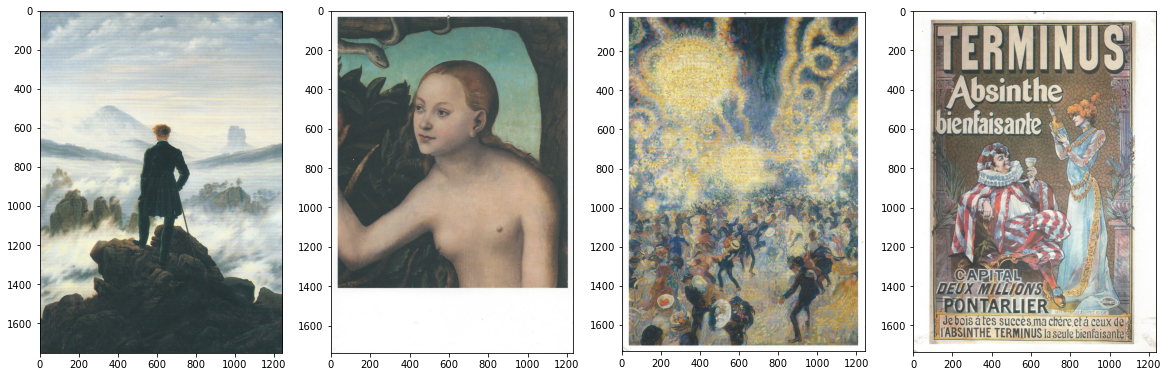

In [5]:
n = 4
base = 10
fig = plt.figure(figsize=(base * n / 2, base))
for el in range(n):
    plt.subplot(1, n, el + 1)
    plt.imshow(vertical_images[el])

In [6]:
image = vertical_images[0]
image.shape

(1752, 1243, 3)

In [7]:
# im = Image.open(vertical_image_paths[2])
# im

# Load a pretrained model

In [8]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

In [59]:
# model

# Preprocessing

In [10]:
processor

CLIPProcessor:
- feature_extractor: CLIPFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "size": 224
}

- tokenizer: PreTrainedTokenizerFast(name_or_path='openai/clip-vit-large-patch14', vocab_size=49408, model_max_len=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<|endoftext|>'})

In [58]:
inputs = processor(
    images=vertical_images,
    return_tensors="pt", 
    padding=True
)
inputs['pixel_values'].shape

torch.Size([63, 3, 224, 224])

## check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


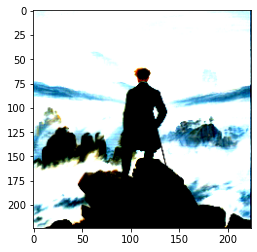

In [12]:
out = inputs['pixel_values'][0].numpy().squeeze().transpose(1, 2, 0)
plt.imshow(out)

# Get the representations from the vision model
projected last layer hidden state

In [14]:
def count_parameters(model):
    """Returns number of model params"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

f"{count_parameters(model.vision_model):.4e} weights"

'3.0318e+08 weights'

In [15]:
device = 'cpu'
vision_model = model.vision_model
vision_model = vision_model.to(device)
visual_projection = model.visual_projection.to(device)

In [56]:
vision_embeddings = []
for i, tensor in tqdm(enumerate(inputs['pixel_values'])):
    x = tensor.unsqueeze(0).to(device)
    vision_output = vision_model(x)
    last_hidden_state_proj = visual_projection(vision_output.last_hidden_state).detach().numpy()
    p = vertical_image_paths[i]
    path = p.parent / (p.stem + '_embedding')
    np.save(path, last_hidden_state_proj)
    print(f"saved to {path}")
    vision_embeddings.append(last_hidden_state_proj)
    del last_hidden_state_proj
    clean_memory()

0it [00:00, ?it/s]

saved to images\vertical\v_1_embedding
saved to images\vertical\v_10_embedding
saved to images\vertical\v_11_embedding
saved to images\vertical\v_12_embedding
saved to images\vertical\v_13_embedding
saved to images\vertical\v_14_embedding
saved to images\vertical\v_15_embedding
saved to images\vertical\v_16_embedding
saved to images\vertical\v_17_embedding
saved to images\vertical\v_18_embedding
saved to images\vertical\v_19_embedding
saved to images\vertical\v_2_embedding
saved to images\vertical\v_20_embedding
saved to images\vertical\v_21_embedding
saved to images\vertical\v_22_embedding
saved to images\vertical\v_23_embedding
saved to images\vertical\v_24_embedding
saved to images\vertical\v_25_embedding
saved to images\vertical\v_26_embedding
saved to images\vertical\v_27_embedding
saved to images\vertical\v_28_embedding
saved to images\vertical\v_29_embedding
saved to images\vertical\v_3_embedding
saved to images\vertical\v_30_embedding
saved to images\vertical\v_31_embedding
sav

In [70]:
vision_embeddings = np.array([np.load(p) for p in vertical_image_dir.glob('*.npy')])
vision_embeddings = vision_embeddings.reshape(vision_embeddings.shape[0], -1)
vision_embeddings.shape

(63, 197376)

# Project onto 2-d space

In [452]:
import numpy as np
from sklearn.manifold import TSNE

# Plot

load the images in the same order as the embedding vectors

In [437]:
paths = [(e.parent / f"v_{e.stem.split('_')[1]}.png") for e in vertical_image_dir.glob('*.npy')]

resize all the images to the mean aspect ratio an the min width

In [616]:
%%time
images_raw = [plt.imread(p) for p in paths]
shapes = np.array([e.shape for e in images_raw])[:, :2,]
min_width = int(shapes[:, 1].min(0) / 5)
min_height = int(round((shapes[:, 0] / shapes[:, 1]).mean() * min_width, -1))
new_size = (min_width, min_height)

images = np.array([cv2.resize(image, new_size) for image in images_raw])

CPU times: total: 3.64 s
Wall time: 3.41 s


In [617]:
images.shape

(63, 300, 212, 3)

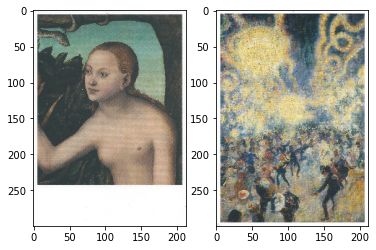

In [618]:
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.subplot(1, 2, 2)
plt.imshow(images[1])

## create canvas

In [619]:
min_deltas = np.abs(np.diff(projections_scaled, axis=0)).min(0)
min_deltas

array([0.01095855, 0.05004787], dtype=float32)

In [620]:
half_size_image = np.array(images.shape[1:-1]) / 2
min_offset_percentage = min_deltas[1]
min_offset_percentage = 0.03
canvas_side = half_size_image.max() / min_offset_percentage
canvas_size = np.array([canvas_side, canvas_side])
canvas_size = (canvas_size + half_size_image.max() * 2).astype(int)
# init the plot as white canvas
canvas = 255 * np.ones((*canvas_size, 3), np.uint8)
canvas.shape

(5300, 5300, 3)

## compute image coordinates

In [398]:
# Compute the coordinates of the image on the plot
def compute_plot_coordinates(x, y, image, canvas, verbose: bool = False):
    image_height, image_width, _ = image.shape
 
    # compute the image center coordinates on the plot
    center_x = int((canvas.shape[1] - image_width) * x + image_width / 2) 
    # + offset
 
    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int((canvas.shape[0] - image_height) * (1 - y) + image_height / 2)
 
    # knowing the image center,
    # compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)
 
    br_x = tl_x + image_width
    br_y = tl_y + image_height
    
    if verbose:
        print(
            f"x, y: ({x:.2f}, {y:.2f}) "
            f"center: ({center_x:<5}, {center_y:<5}) "
            f"top left: ({tl_x:<5}, {tl_y:<5}) "
            f"bottom right: ({br_x:<5}, {br_y:<5}) "
            f"y diff ({tl_y-br_y}) "
            f"x diff ({tl_x-br_x})"
        )
 
    return tl_x, tl_y, br_x, br_y

In [401]:
x, y = projections_scaled[18]
tl_x, tl_y, br_x, br_y = compute_plot_coordinates(x, y, images[0], canvas, verbose=True)

x, y: (0.67, 1.00) center: (4921 , 95   ) top left: (4855 , 0    ) bottom right: (4987 , 190  ) y diff (-190) x diff (-132)


## draw images in the canvas

In [631]:
%%time
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=60, verbose=1, n_iter=2000)
projections = tsne.fit_transform(vision_embeddings)
# min-max scaling
projections_scaled = (projections - projections.min(0)) / np.ptp(projections, axis=0)
projections_scaled.shape

[t-SNE] Computing 62 nearest neighbors...
[t-SNE] Indexed 63 samples in 0.018s...
[t-SNE] Computed neighbors for 63 samples in 0.418s...
[t-SNE] Computed conditional probabilities for sample 63 / 63
[t-SNE] Mean sigma: 83.321401
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.659660
[t-SNE] KL divergence after 1200 iterations: 0.014881
CPU times: total: 6.5 s
Wall time: 959 ms


(63, 2)

  0%|          | 0/63 [00:00<?, ?it/s]

(-0.5, 7949.5, 7949.5, -0.5)

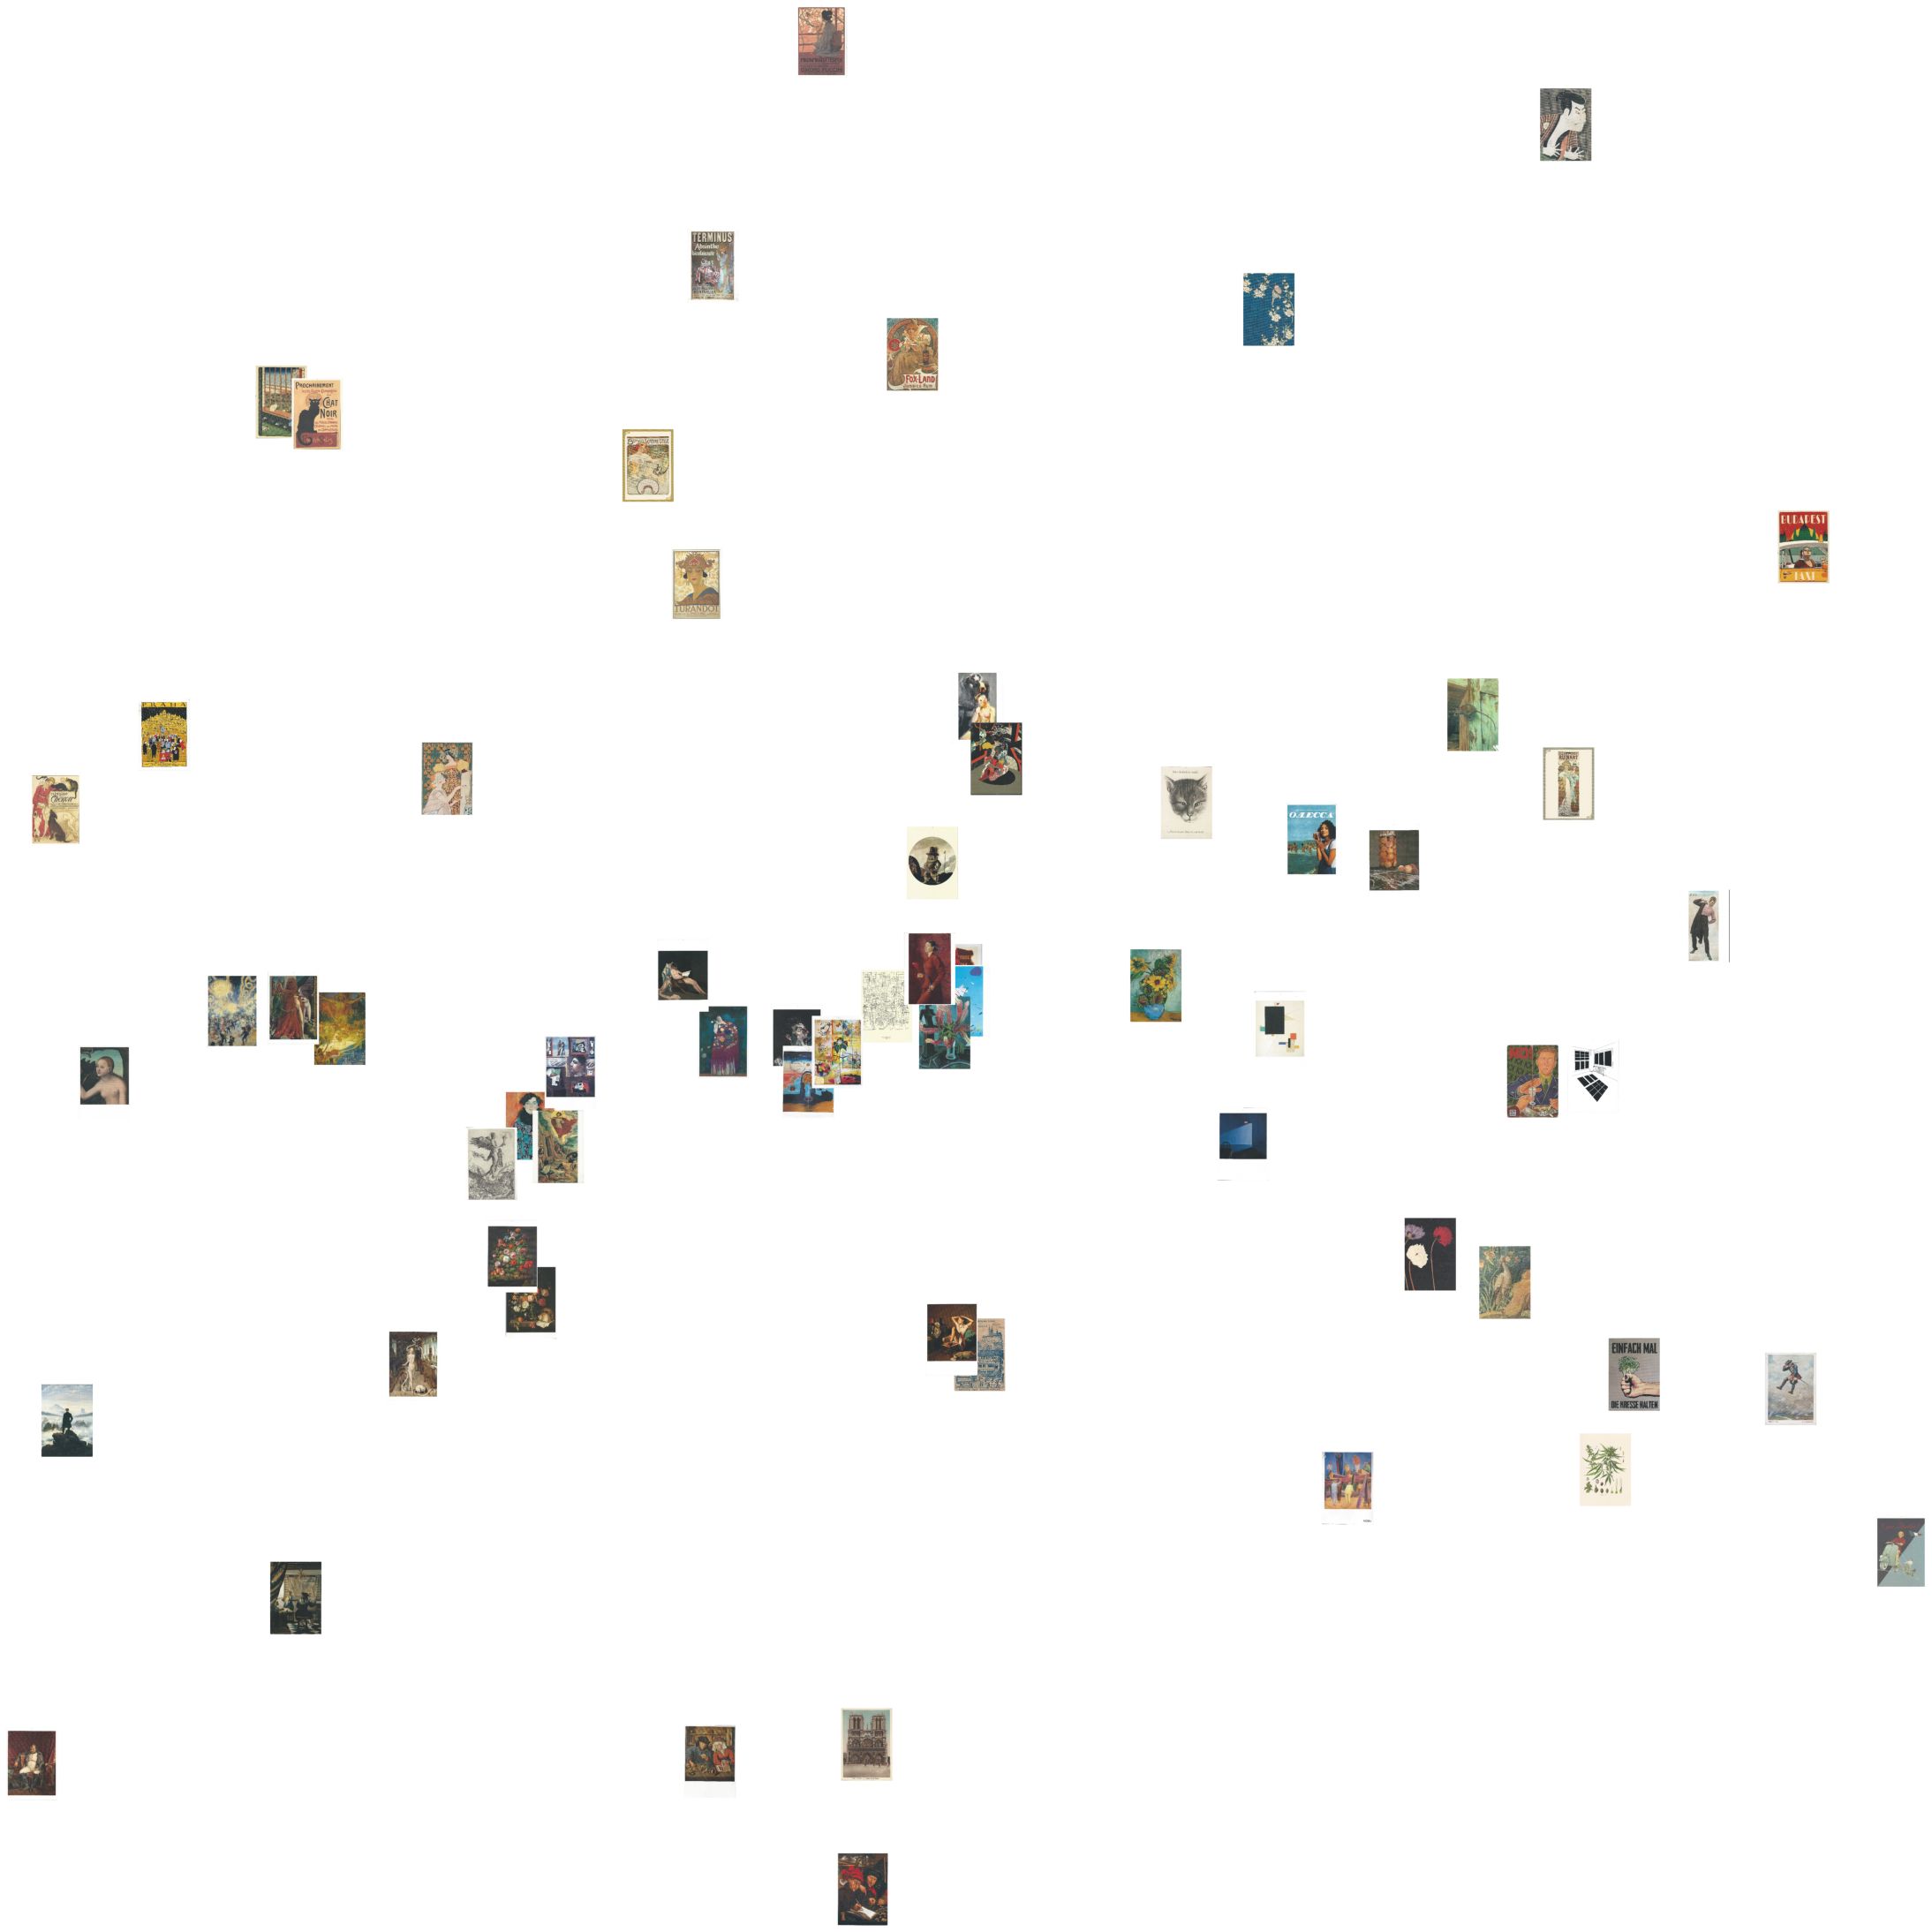

In [636]:
canvas = 255 * np.ones((*(canvas_size * 1.5).astype(int), 3), np.uint8)
for image, (x, y) in tqdm(zip(images, projections_scaled), total=len(images)):
    tl_x, tl_y, br_x, br_y = compute_plot_coordinates(x, y, image, canvas, verbose=False)
    canvas[tl_y:br_y, tl_x:br_x, :] = (255 * image).astype(int)
    
figure = plt.figure(figsize=(40,40))
plt.imshow(canvas)
plt.axis('off')

In [637]:
figure.savefig(IMAGE_DIR / 'clip_embed_tsne.png', dpi=1000)

# Projection of raw pixel values

In [576]:
%%time
images_raw = [plt.imread(p) for p in paths]
shapes = np.array([e.shape for e in images_raw])[:, :2,]
min_width = int(shapes[:, 1].min(0) / 2)
min_height = int(round((shapes[:, 0] / shapes[:, 1]).mean() * min_width, -1))
new_size = (min_width, min_height)

images = np.array([cv2.resize(image, new_size) for image in images_raw])
image_pixels = images.reshape(images.shape[0], -1)

CPU times: total: 4.58 s
Wall time: 3.61 s


In [525]:
vision_embeddings.shape

(63, 197376)

In [543]:
images[0].flatten().shape

(302100,)

In [581]:
%%time
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=60, verbose=1, n_iter=2000)
projections = tsne.fit_transform(image_pixels)
# min-max scaling
projections_scaled = (projections - projections.min(0)) / np.ptp(projections, axis=0)
projections_scaled.shape

[t-SNE] Computing 62 nearest neighbors...
[t-SNE] Indexed 63 samples in 0.064s...
[t-SNE] Computed neighbors for 63 samples in 2.533s...
[t-SNE] Computed conditional probabilities for sample 63 / 63
[t-SNE] Mean sigma: 431.992680
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.218964
[t-SNE] KL divergence after 800 iterations: 0.004745
CPU times: total: 8.17 s
Wall time: 3.02 s


(63, 2)

  0%|          | 0/63 [00:00<?, ?it/s]

(-0.5, 6711.5, 6711.5, -0.5)

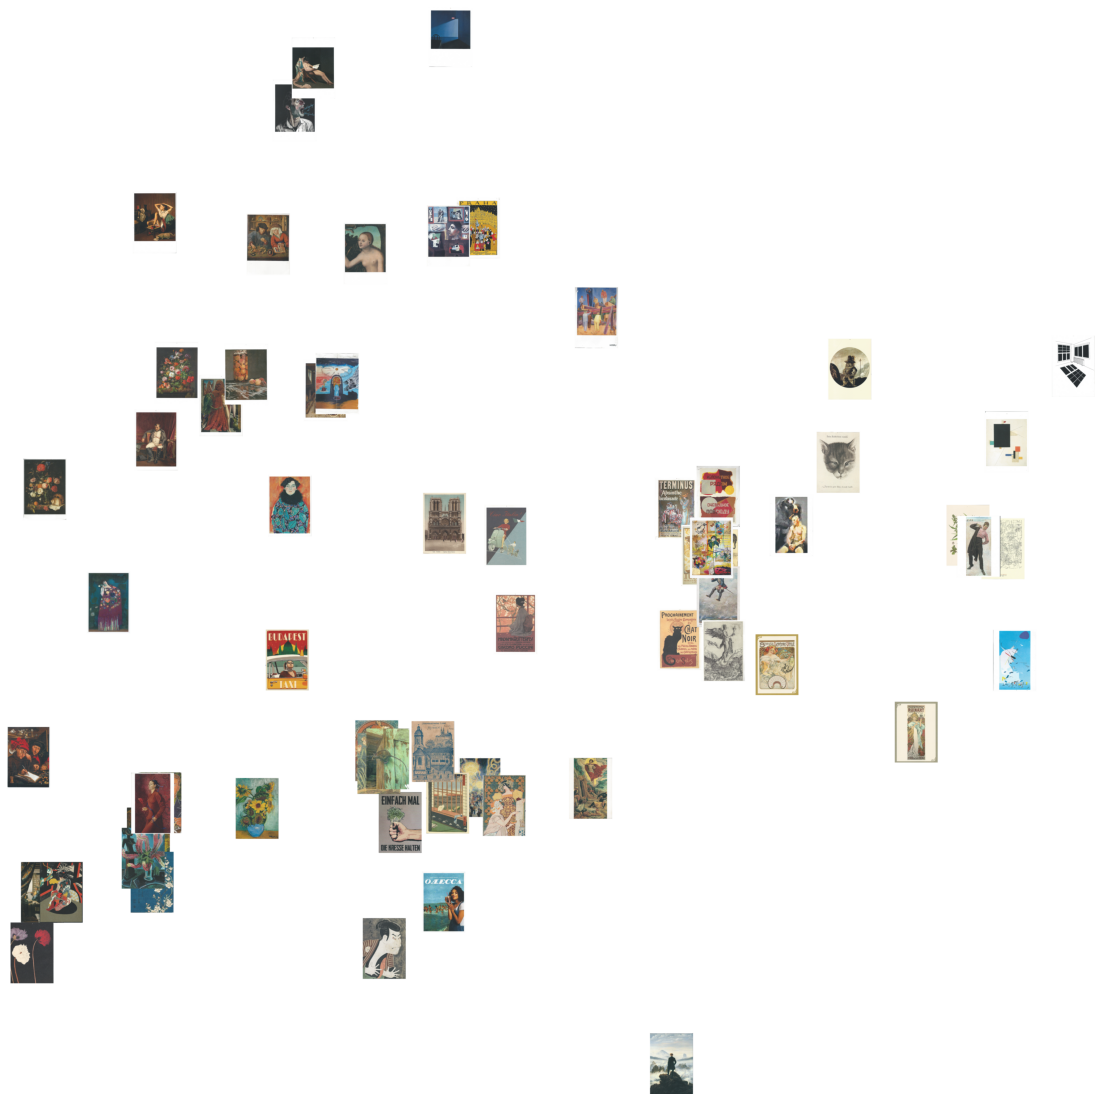

In [597]:
canvas = 255 * np.ones((*(canvas_size*2).astype(int), 3), np.uint8)
for image, (x, y) in tqdm(zip(images, projections_scaled), total=len(images)):
    size = (np.array(image.shape[:2]) / 2).astype(int)
    image = cv2.resize(image, (size[1], size[0]))
    tl_x, tl_y, br_x, br_y = compute_plot_coordinates(x, y, image, canvas, verbose=False)
    canvas[tl_y:br_y, tl_x:br_x, :] = (255 * image).astype(int)
    
figure = plt.figure(figsize=(20,20))
plt.imshow(canvas)
plt.axis('off')